# Using the DNMT3A subgroup to recreate the Figure 6 scatterplot from the Palma paper
***

### Importing BMatrix and BooleanNetwork code

In [2]:
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt

# import booleanNetwork module from ./src
import sys
sys.path.append('./src/')
sys.path.append('./src/BNMPy/')

import booleanNetwork as bn
import BMatrix  

#importing dataframe with patient id, mutation_profiles, and clinical_data
merged_df = pd.read_excel("./input_files/merged_df.xlsx",keep_default_na=False)

In [4]:
np.__version__

'1.23.5'

In [5]:
pd.__version__

'2.2.2'

In [3]:
merged_df

,labId,mutation_profiles,BM_Blast,PB_Blast
0,09-00705,NPM1,94.000000,97.000000
1,10-00136,"FLT3,DNMT3A",80.000000,19.000000
2,10-00172,FLT3,91.000000,99.000000
3,10-00507,"FLT3,NPM1",97.000000,97.000000
4,10-00542,"FLT3,DNMT3A",87.000000,80.000000
...,...,...,...,...
603,16-01262,,90.000000,90.000000
604,16-01270,,55.694882,41.515937
605,17-00072,,55.694882,53.200000
606,17-00077,,90.000000,74.000000


### Getting the variables needed for the simulation (like varF and F)

In [3]:
file = './input_files/dnmt3a_equations.txt' #does not have the equations at the end

equations = BMatrix.get_equations(file)
gene_dict = BMatrix.get_gene_dict(equations)
upstream_genes = BMatrix.get_upstream_genes(equations)

connectivity_matrix = BMatrix.get_connectivity_matrix(equations,upstream_genes,gene_dict)
print(connectivity_matrix)
print('\n')

truth_table = BMatrix.get_truth_table(equations,upstream_genes)
print(truth_table)

ngenes= len(equations)

[[ 0 -1 -1]
 [ 0 -1 -1]
 [ 0 -1 -1]
 [ 3 -1 -1]
 [ 1 -1 -1]
 [ 5 -1 -1]
 [ 5 -1 -1]
 [ 5 -1 -1]
 [ 5 -1 -1]
 [ 0 -1 -1]
 [ 5 -1 -1]
 [ 0 -1 -1]
 [ 2 -1 -1]
 [ 4  3 -1]
 [ 7  3 -1]
 [ 4  9  8]
 [ 9 -1 -1]
 [ 6 -1 -1]
 [17  9 -1]]


[[ 0  1 -1 -1 -1 -1 -1 -1]
 [ 0  1 -1 -1 -1 -1 -1 -1]
 [ 1  0 -1 -1 -1 -1 -1 -1]
 [ 0  1 -1 -1 -1 -1 -1 -1]
 [ 1  0 -1 -1 -1 -1 -1 -1]
 [ 0  1 -1 -1 -1 -1 -1 -1]
 [ 0  1 -1 -1 -1 -1 -1 -1]
 [ 1  0 -1 -1 -1 -1 -1 -1]
 [ 0  1 -1 -1 -1 -1 -1 -1]
 [ 0  1 -1 -1 -1 -1 -1 -1]
 [ 0  1 -1 -1 -1 -1 -1 -1]
 [ 0  1 -1 -1 -1 -1 -1 -1]
 [ 1  0 -1 -1 -1 -1 -1 -1]
 [ 1  0  0  0 -1 -1 -1 -1]
 [ 1  0  1  1 -1 -1 -1 -1]
 [ 0  0  1  0  0  0  0  0]
 [ 1  0 -1 -1 -1 -1 -1 -1]
 [ 0  1 -1 -1 -1 -1 -1 -1]
 [ 0  1  0  0 -1 -1 -1 -1]]


In [4]:
file_equations = './input_files/calculating_equations.txt'

cal_equations = BMatrix.get_equations(file_equations)
cal_upstream_genes = BMatrix.get_cal_upstream_genes(cal_equations)
cal_functions = BMatrix.get_cal_functions(cal_equations)

In [5]:
file_mutations = './input_files/mutations.txt'

mutation_dict = BMatrix.get_mutation_dict(file_mutations)
#mutation_dict

### Running the simulation for all the 8 profiles from merged_df and getting the final scores

In [6]:
all_profiles = np.array([[profile] for profile in merged_df['mutation_profiles'].unique()])

In [7]:
final_scores = {}
networks = {}

for i in range(len(all_profiles)): 
    profile = all_profiles[i,0] # Gets the profile as a string ex. 'FLT3'
    print(profile)
    
    mutated_connectivity_matrix, x0 = BMatrix.get_knocking_genes(profile, mutation_dict, connectivity_matrix, gene_dict)

    #making the networks and running the simulation
    print('starting simulation')
    network = bn.BooleanNetwork(ngenes, mutated_connectivity_matrix, truth_table, x0)
    network_traj = network.update_noise(0.05, 200000)
    
    #calculating the scores  
    print('getting final score')
    cal_range = network_traj[-100000:]
    
    scores_dict, final_score = BMatrix.get_calculating_scores(network_traj, cal_functions, cal_upstream_genes, gene_dict, cal_range)

    print(final_score)
    
    final_scores.update({profile: final_score})
    
print(final_scores)

NPM1
starting simulation
getting final score
0.60275
FLT3,DNMT3A
starting simulation
getting final score
4.81504
FLT3
starting simulation
getting final score
3.97588
FLT3,NPM1
starting simulation
getting final score
2.41684
DNMT3A,NPM1
starting simulation
getting final score
1.63099
FLT3,DNMT3A,NPM1
starting simulation
getting final score
3.62925
DNMT3A
starting simulation
getting final score
2.34628

no_mutation
starting simulation
getting final score
1.8547
{'NPM1': 0.60275, 'FLT3,DNMT3A': 4.81504, 'FLT3': 3.97588, 'FLT3,NPM1': 2.41684, 'DNMT3A,NPM1': 1.63099, 'FLT3,DNMT3A,NPM1': 3.62925, 'DNMT3A': 2.34628, '': 1.8547}


## Creating the PB and BM dataframes for the scatterplots

#### Grouping the patients with the same profiles together and getting their average scores

In [8]:
PB_Blast = []
BM_Blast = []
Network_Scores = []

for i in range(len(all_profiles)):
    mutation_group = all_profiles[i,0] # Gets the profile as a string ex. 'FLT3'

    group_df = merged_df[merged_df['mutation_profiles'] == mutation_group]

    #network scores
    score = final_scores[mutation_group]
    Network_Scores.append(score)
    
    #PB Blast
    PB = group_df['PB_Blast'].mean()
    PB_Blast.append(PB)
    
    #BM Blast
    BM = group_df['BM_Blast'].mean()
    BM_Blast.append(BM)
    
Mutation_Profiles = [profile[0] for profile in all_profiles]
Mutation_Profiles = ['WT' if item == '' else item for item in Mutation_Profiles]

#### Plotting the scatterplots

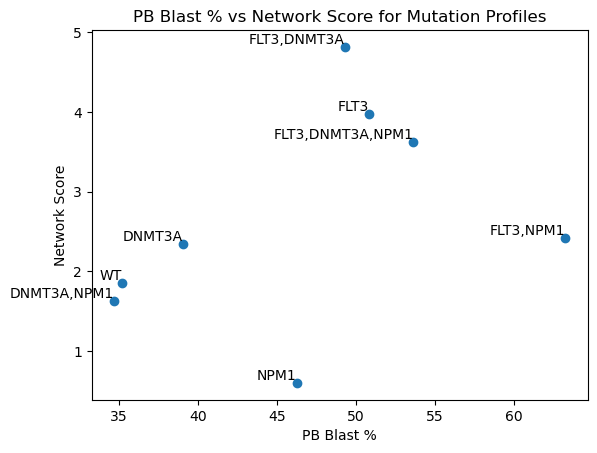

Text(0.5, 1.0, 'Regression Plot: PB_Blast vs. Network_Scores')

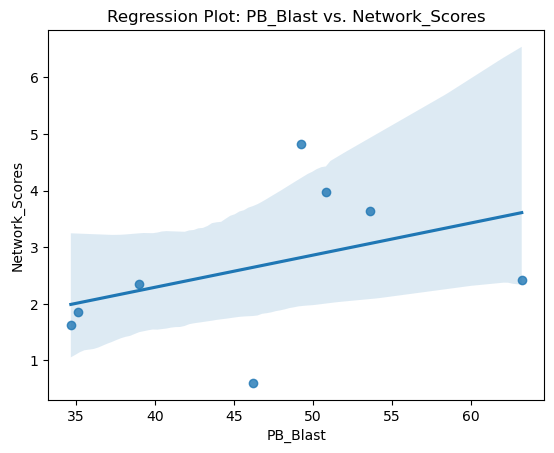

In [9]:
PB_v_Network = pd.DataFrame({
    'Mutation_Profiles': Mutation_Profiles,
    'PB_Blast': PB_Blast,
    'Network_Scores': Network_Scores
})

plt.scatter(PB_v_Network['PB_Blast'], PB_v_Network['Network_Scores'])

for x, y, label in zip(PB_v_Network['PB_Blast'], PB_v_Network['Network_Scores'], PB_v_Network['Mutation_Profiles']):
    plt.text(x, y, label, ha='right', va='bottom')

plt.xlabel('PB Blast %')
plt.ylabel('Network Score')
plt.title('PB Blast % vs Network Score for Mutation Profiles')
plt.show()

sns.regplot(x='PB_Blast', y='Network_Scores', data=PB_v_Network, fit_reg=True)
plt.title('Regression Plot: PB_Blast vs. Network_Scores')

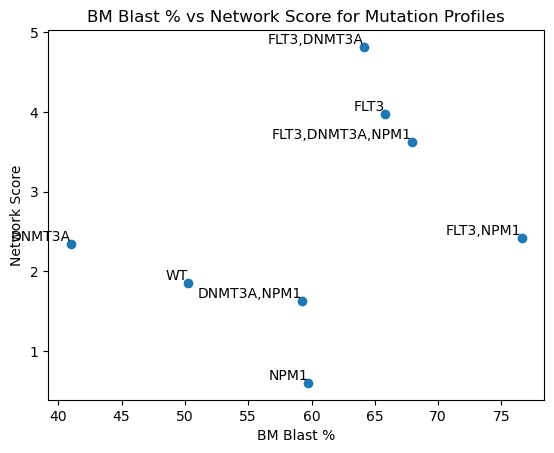

Text(0.5, 1.0, 'Regression Plot: BM_Blast vs. Network_Scores')

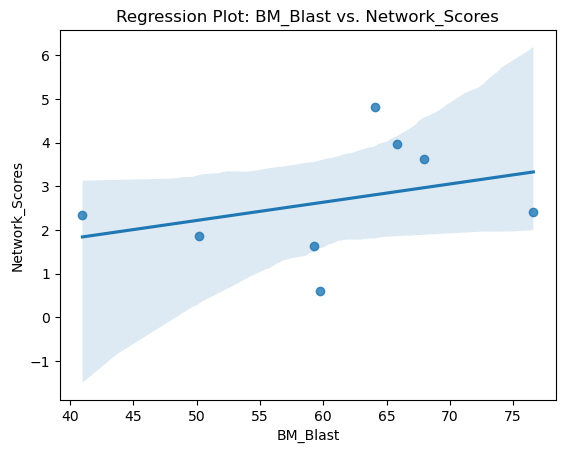

In [10]:
BM_v_Network = pd.DataFrame({
    'BM_Blast': BM_Blast,
    'Network_Scores': Network_Scores,
    'Mutation_Profiles': Mutation_Profiles  # Assuming Mutation_Profiles is a list
})

plt.scatter(BM_v_Network['BM_Blast'], BM_v_Network['Network_Scores'])

for x, y, label in zip(BM_v_Network['BM_Blast'], BM_v_Network['Network_Scores'], BM_v_Network['Mutation_Profiles']):
    plt.text(x, y, label, ha='right', va='bottom')

plt.xlabel('BM Blast %')
plt.ylabel('Network Score')
plt.title('BM Blast % vs Network Score for Mutation Profiles')
plt.show()

sns.regplot(x='BM_Blast', y='Network_Scores', data=BM_v_Network, fit_reg=True)
plt.title('Regression Plot: BM_Blast vs. Network_Scores')

#### Getting the pearson correlation

In [11]:
from scipy.stats import pearsonr

pearson_PB, _ = pearsonr(PB_Blast, Network_Scores)
pearson_BM, _ = pearsonr(BM_Blast, Network_Scores)

print("\nPearson correlation for PB vs Network:", pearson_PB)
print("Pearson correlation for BM vs Network:", pearson_BM)


Pearson correlation for PB vs Network: 0.40510285374298105
Pearson correlation for BM vs Network: 0.3317927995860926
